<a href="https://colab.research.google.com/github/hanyoseob/lecture_optimization/blob/main/chapter01_Inverse_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Inverse problem](https://en.wikipedia.org/wiki/Inverse_problem)
---

Below Steps [1-5] shows that how to generate the Gaussian-blurred image $y$ from the clean image $x$. If the Gaussian-blur kernel is defined as a system matrix $A$, the Gaussian-blurred image $y$ is formulated as

> $y = Ax$.

Here, an inverse problem can be described as reconstructing a deblurred image $\tilde{x}$ from the Gaussian-blurred image $y$.
Easy way to solve the inverse problem is calculating an inverse matrix/operator $A^{-1}$ of the system matrix/operator $A$. Then, the deblurred image $\tilde{x}$ is calculated as

> $\tilde{x} = A^{-1}y$.

If the above situation is satisfied, the system matrix $A$ has a low [condition number](https://en.wikipedia.org/wiki/Condition_number). In other words, the problem caused by the system matrix $A$ is well-posed problem ( = well-conditioned problem ). 

However, the system matrixes $A$ in the world have a high [condition number](https://en.wikipedia.org/wiki/Condition_number), so its problem is ill-posed ( = ill-conditioned ). Since the ill-posed problem due to high [condition number](https://en.wikipedia.org/wiki/Condition_number) is difficult to calculate the inverse matrix $A^{-1}$, an [optimization problems](https://en.wikipedia.org/wiki/Mathematical_optimization) have been developed to address the ill-posed problems.

# Implementation
---
Here, we will implement a forward model using Gaussian kernel.

> $y = Ax$

where $A$ denotes a Gaussian-blur kernel, and $x$ and $y$ are a clean image and output of forward system, respectively.

The implementation steps are structured as follows.

1. Add packages
2. Define 2D [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)
3. Set the system matrix $A$ and its [transpose](https://en.wikipedia.org/wiki/Transpose) $A^T$
4. Load the clean image $x$
5. Apply the forward model $A$ to the clean image $x$
6. Calculate the quantitative metrics
7. Plot the images

## Step 1. Add packages

In [ ]:
# Mathmetical packages
import numpy as np
from scipy.signal import convolve

# Image processing package
from skimage import data
from skimage.transform import resize

# Metrics calculating packages
from skimage.metrics import normalized_root_mse as compare_nmse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Ploting packages
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# Ploting options
font = {'family': 'normal',
        'weight': 'bold',
        'size': 10}

matplotlib.rc('font', **font)


## Step 2. Define [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)

> $f(x, y) = A \exp \left( -{\left( {\frac{(x - x_0)^2}{2\sigma_X^2}} + {\frac{(y - y_0)^2}{2\sigma_Y^2}} \right)} \right),$

where $A$ is the amplitude, $x_0$ and $y_0$ are the center positions, $\sigma_X$ and $\sigma_Y$ are the standard deviations.

In [ ]:
def gaus2d(nx, ny, x0=0, y0=0, sgmx=3, sgmy=3, A=1):

    x = np.linspace(-nx/2, nx/2, nx)
    y = np.linspace(-ny/2, ny/2, ny)
    x, y = np.meshgrid(x, y)

    ker = A * np.exp(-(0.5*((x - x0)/sgmx)**2 + 0.5*((y - y0)/sgmy)**2))
    ker = ker / np.sum(ker)

    return ker


## Step 3. Set the system matrix $A$ and its transpose $A^T$

__If you are not familiar with the concept of the transpose, please check out [my lecture video related to transpose](https://www.youtube.com/watch?v=erdPhFEoFYc) and [wikipedia](https://en.wikipedia.org/wiki/Transpose).__ 

In [ ]:
# Generate Gaussian kernel
K = 15    # size of the Gaussian kernel (*the size of kernel must be matched with 'ODD NUMBER'.)
MEAN = 0  # mean of Gaussian kernel
SGM = 3   # standard deviation of Gaussian kernel

ker = gaus2d(K, K, x0=MEAN, y0=MEAN, sgmx=SGM, sgmy=SGM)

# Define the System operator (A) and its transpose (AT)
# A: Convolution operation with Gaussian kernel
# AT: Convolution operation with fliped Gaussian kernel
A = lambda x: convolve(x, ker, mode='same')
AT = lambda y: convolve(y, np.flip(np.flip(ker, axis=0), axis=1), mode='same')


## Step 4. Load the clean image


In [ ]:
# Load the clean image ( = ground truth )
N = 512   # number of rows for the image
M = 512   # number of colums for the image

x_gt = data.camera().astype(dtype=np.float64)/255.0
x_gt = resize(x_gt, output_shape=(N, M))


## Step 5. Apply the forward model $A$ to the clean image $x$

In [ ]:
# Generate the output from the system operator A
y = A(x_gt)


## Step 6. Calculate the quantitative metrics

1. [NMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
2. [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
3. [SSIM](https://en.wikipedia.org/wiki/Structural_similarity)

In [ ]:
# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_gaus = y

nmse_gaus = compare_nmse(x_gt, x_gaus)
psnr_gaus = compare_psnr(x_gt, x_gaus)
ssim_gaus = compare_ssim(x_gt, x_gaus)

print('Result from Gaussian-blurred')
print('NSME: %.4e' % nmse_gaus)
print('PSNR: %.4f' % psnr_gaus)
print('SSIM: %.4f' % ssim_gaus)
print(' ')

Result from Gaussian-blurred
NSME: 1.1977e-01
PSNR: 24.0498
SSIM: 0.8574
 


## Step 7. Plot the images

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


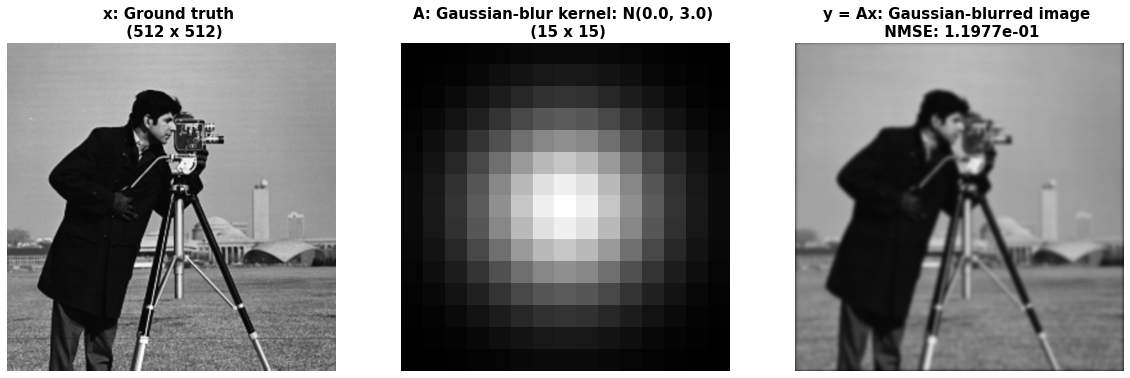

In [ ]:
# Plot the images
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 8))

axs[0].imshow(x_gt, vmin=0, vmax=1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('x: Ground truth \n (%d x %d)' % (N, M), fontsize=15, fontweight='bold')

axs[1].imshow(ker, cmap='gray')
axs[1].axis('off')
axs[1].set_title('A: Gaussian-blur kernel: N(%.1f, %.1f) \n (%d x %d)' % (MEAN, SGM, K, K), fontsize=15, fontweight='bold')

axs[2].imshow(y, vmin=0, vmax=1, cmap='gray')
axs[2].axis('off')
axs[2].set_title('y = Ax: Gaussian-blurred image \n NMSE: %.4e' % (nmse_gaus), fontsize=15, fontweight='bold')

plt.show()


# Conclusion
---
In this chapter, we studied according to the concept of the inverse problem. Generally speaking, the inverse problem is to find the unknown underlying signal $x$ from the measurement $y = Ax$ collected from the system matrix/operator $A$:

> $y = Ax$,

where $y$ is the measurement, $A$ is system matrix/operator, and $x$ denotes the underlying signal.


#Reference
---

1. [Inverse problem](https://en.wikipedia.org/wiki/Inverse_problem)
2. [condition number](https://en.wikipedia.org/wiki/Condition_number)
3. [optimization problems](https://en.wikipedia.org/wiki/Mathematical_optimization)
4. [transpose](https://en.wikipedia.org/wiki/Transpose)
5. [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)
6. [Noramlized Root Mean Square Error (NRMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
7. [Peak Signal to Noise Ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
8. [Structural Similarity Index Measure (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity)


# Next
---

Next chapter, we will study an optimization problem and implement a [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent) to solve the simple optimization prolblem.